**data & label 資料位置**

- https://drive.google.com/file/d/1a7IPxCNENdIj_UmU0qM-nl3-WRwkMa_6/view?usp=sharing
- https://drive.google.com/file/d/1oNj8b-rnJiYcAKRKMxu4kGCow-mELTkG/view?usp=sharing


In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title 從Google Drive 匯入 data & label 資料
train_data_path = '/content/drive/MyDrive/aidataset/lstm_40fpv_data.npy' #@param {type:"string"}
train_label_path =  '/content/drive/MyDrive/aidataset/lstm_40fpv_labels.npy' #@param {type:"string"}
cmd  = f'cp {train_data_path} ./lstm_data.npy'
! $cmd
cmd  = f'cp {train_label_path} ./lstm_labels.npy'
! $cmd

In [8]:
#@title 載入 rnn 模型函數
def rnn_models(model_name, train_data):
    main_input = Input(
        shape=(train_data.shape[1],
               train_data.shape[2]),
        name="main_input"
    )   

    if model_name == "lstm":
        headModel = LSTM(32)(main_input)

    elif model_name == "bidirectional":
        headModel = Bidirectional(LSTM(256, return_sequences=True))(main_input)
        headModel = LSTM(32)(headModel)

    predictions = Dense(
        2,
        activation="softmax",
        kernel_initializer="he_uniform"
    )(headModel)
    model = Model(inputs=main_input, outputs=predictions)

    # Model compilation
    # opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / EPOCHS)
    optimizer = Nadam(
        lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004
    )
    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model

In [13]:
#@title 建立 rnn 模型
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Dense
from keras.models import Model
import numpy as np
import imageio.core.util
from PIL import Image
import cv2
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.layers import Input, LSTM, Bidirectional
from random import shuffle
from os import listdir
import glob
from os.path import join
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
# Training dataset loading
train_data = np.load("lstm_data.npy")
train_label = np.load("lstm_labels.npy")
train_label = utils.to_categorical(train_label)
print("Dataset Loaded...")

# Train validation split
trainX, valX, trainY, valY = train_test_split(
    train_data, train_label, shuffle=True, test_size=0.1
)

model_choice = 'lstm' #@param ["lstm", "bidirectional"]
model = rnn_models(model_choice,train_data)

trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.trainable_weights)])
)
non_trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])
)

# Number of trainable and non-trainable parameters
print("Total params: {:,}".format(trainable_count + non_trainable_count))
print("Trainable params: {:,}".format(trainable_count))
print("Non-trainable params: {:,}".format(non_trainable_count))



Dataset Loaded...
Total params: 69,826
Trainable params: 69,826
Non-trainable params: 0


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [15]:
#@title 模型訓練 
epoch_num =  10 #@param {type:"integer"}
H = model.fit(
    trainX,
    trainY,
    validation_data=(valX, valY),
    batch_size=32,
    epochs=epoch_num,
    shuffle=True
)


Train on 148 samples, validate on 17 samples
148/148 [==============================] - 1s 4ms/sample - loss: 0.1905 - accuracy: 0.9459 - val_loss: 0.0662 - val_accuracy: 1.0000


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


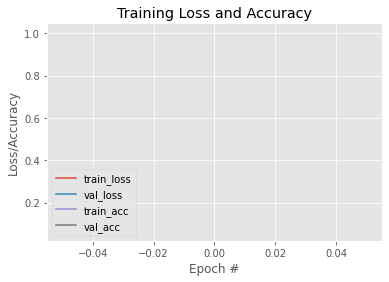

In [17]:
#@title 繪製訓練損失與準確率變化
from matplotlib import pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = len(H.history["loss"])
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")